In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train_data = pd.read_csv("../input/titanic/train.csv")
test_data = pd.read_csv("../input/titanic/test.csv")
combine = [train_data, test_data]

In [4]:
# Check data
train_data = train_data.fillna(np.nan)

missing_values_count = train_data.isnull().sum()
print(missing_values_count)

total_cells = np.product(train_data.shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print("Percent of missing values: ", percent_missing)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Percent of missing values:  8.099513655069211




Feature analysis




Numerical variables


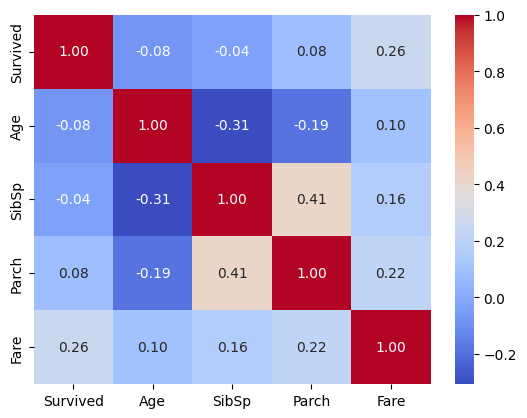

In [5]:
g = sns.heatmap(train_data[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, fmt=".2f", cmap="coolwarm")

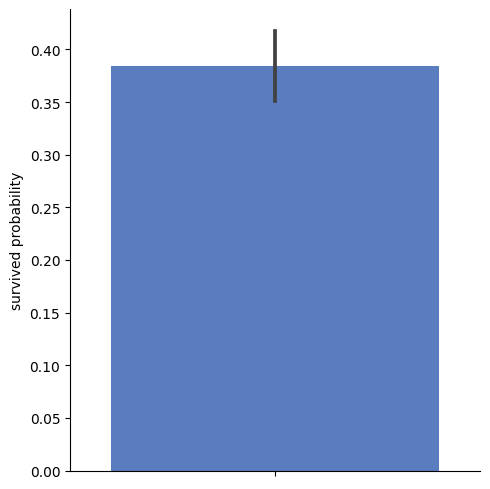

In [6]:
g = sns.catplot(hue="SibSp", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("survived probability")

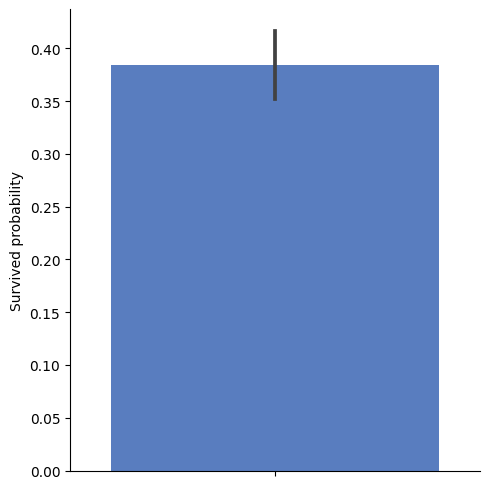

In [7]:
g = sns.catplot(hue="Parch", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survived probability")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


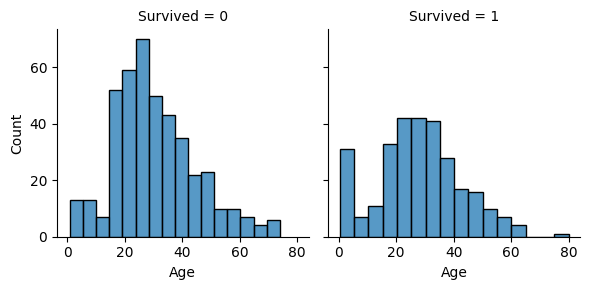

In [8]:
g = sns.FacetGrid(data=train_data, col="Survived")
g = g.map(sns.histplot, "Age")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


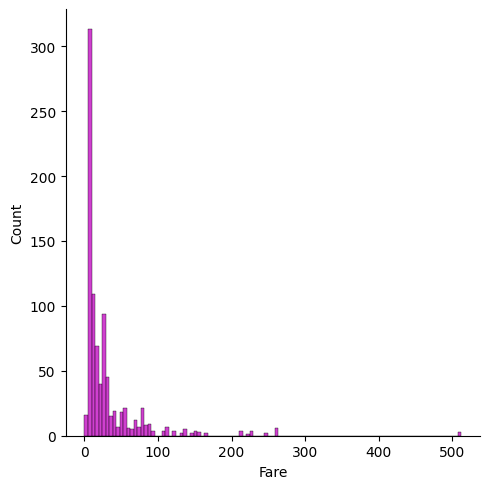

In [9]:
g = sns.displot(train_data["Fare"], color="m", label="Skewness: %.2f"%(train_data["Fare"].skew()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


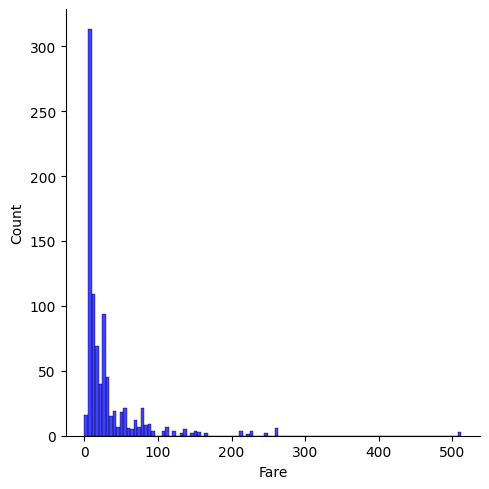

In [10]:
# Apply log to Fare to reduce skewness distribution
g = sns.displot(train_data["Fare"], color="b", label="Skewness: %.2f"%(train_data["Fare"].skew()))



Categorical variables


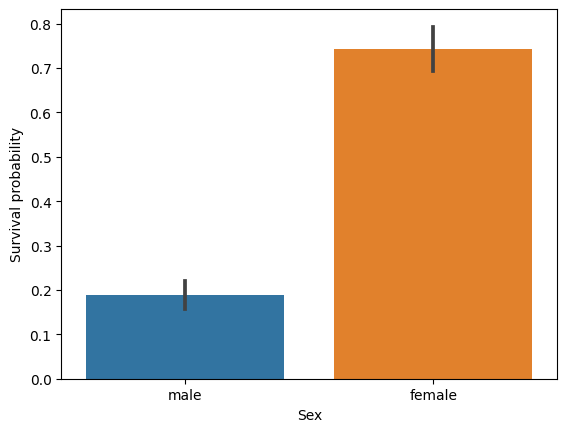

In [11]:
g = sns.barplot(x="Sex", y="Survived", data=train_data)
g = g.set_ylabel("Survival probability")

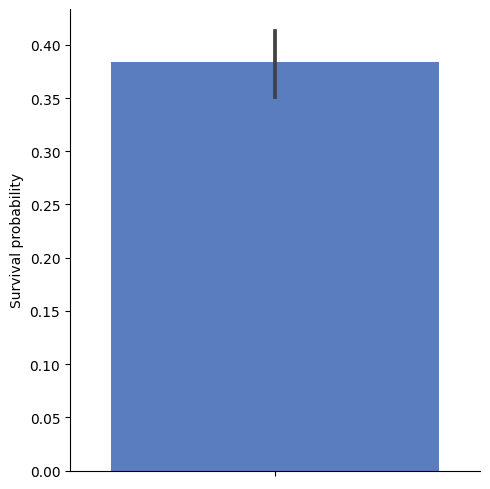

In [12]:
g = sns.catplot(hue="Pclass", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survival probability")

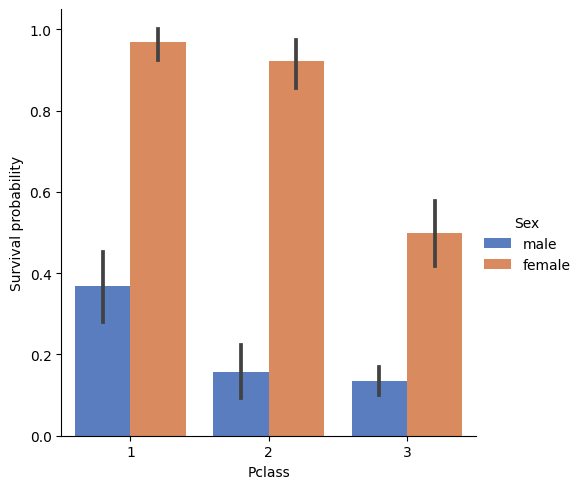

In [13]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train_data, kind="bar", palette="muted")
g = g.set_ylabels("Survival probability")

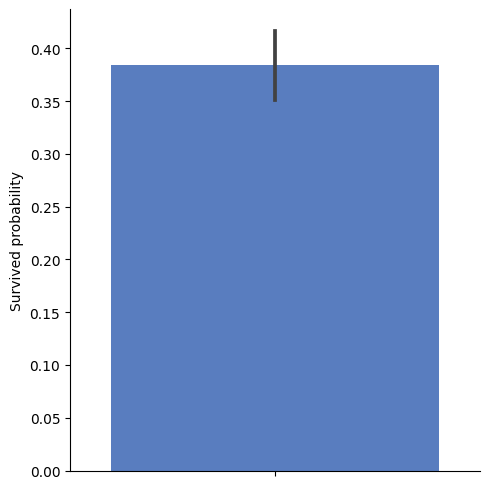

In [14]:
g = sns.catplot(hue="Embarked", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survived probability")

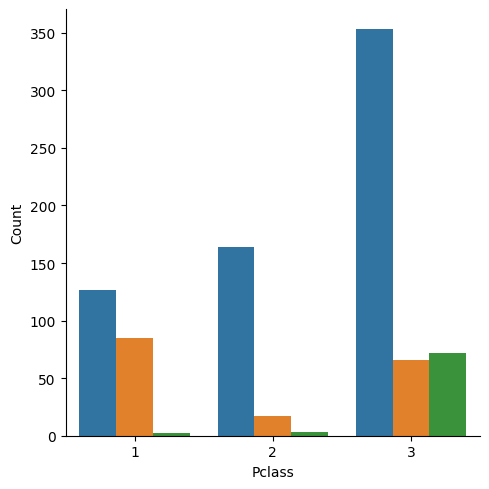

In [15]:
g = sns.catplot(x="Pclass", hue="Embarked", data=train_data, kind="count", legend=False)
g = g.set_ylabels("Count")

Preprocessing

In [16]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [18]:
print("B:", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

train_data = train_data.drop(['Ticket', 'Cabin'], axis=1)
test_data = test_data.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_data, test_data]

print("A:", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

B: (891, 12) (418, 11) (891, 12) (418, 11)
A: (891, 10) (418, 9) (891, 10) (418, 9)


In [19]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [20]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [21]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in combine:
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Title'] = dataset['Title'].map(titles)

In [22]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [23]:
print("B:", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

train_data = train_data.drop(['Name', 'PassengerId'], axis=1)
test_data = test_data.drop(['Name'], axis=1)
combine = [train_data, test_data]

print("A:", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

B: (891, 11) (418, 10) (891, 11) (418, 10)
A: (891, 9) (418, 9) (891, 9) (418, 9)


In [24]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)
    
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [25]:
guess_ages = np.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(2):
        for j in range(3):
            guess_ds = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_ds.median()
            
            guess_ages[i, j] = int(age_guess / .5 + .5) * .5
            
    for i in range(2):
        for j in range(3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]
            
    dataset['Age'] = dataset['Age'].astype(int)
    
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [26]:
freq_port = train_data.Embarked.dropna().mode()[0]

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

In [27]:
print(train_data.isnull().sum())
train_data.head()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Save predictions

In [28]:
# output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)

# print("Your submission was successfully saved!")